# EAS503 - Final Project Code

In [1]:
GroupNumber = 19

ProjectTitle = "911 - What & How Well Do They Serve?"

GroupMembers = {"Akshayah Karuppayammal Chinnasamy": 50419478, 
                "Sri Balaji Muruganandam": 50414549, 
                "Abhishek Pughazhendhi": 50414407}

#### Importing The Required Packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import csv
from sqlite3 import Error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

In [3]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

In [4]:
def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name:
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [5]:
conn = create_connection('non_normalized.db')

In [6]:
endtoend = pd.read_csv('endtoend.csv')
endtoend.head(1)

,Week Start Date,Agency,Final Incident Type,# of Incidents Calculated,Call to First Pickup,Call to PD Calltaker Handoff,Call to FDNY Pickup,Call to FDNY Job Creation,Call to EMS Pickup,Call to Agency Job Creation,...,Median Travel,Median Cumulative First Arrival (Multi-Agency Incidents),Average Travel,Average Dispatch,Average EMS Processing,Average EMS Pickup,Average Calltaker Processing,Average Pickup,Average FD Pickup,Average FD Processing
0,12/29/2014,EMS,1. Life Threating Med Emergencies,8881,3.02,60.84,NaN,NaN,68.1,128.32,...,329.5,427.75,6.05,1.58,0.87,0.15,0.97,0.05,NaN,NaN



## **Generating the [OPEN DATA] table**

1.   Loading the "opendata.csv" into the environment
2.   Creating the "non_normalized.db"
3.   Writing the necessary functions for table creation and value insertion.
4.   Parsing through the CSV file to clean it and insert it into the table.








In [7]:
sql_statement = "DROP TABLE IF EXISTS [OPEN DATA]"
execute_sql_statement(sql_statement, conn)

sql_statement = """CREATE TABLE [OPEN DATA](
"MonthName" TEXT,
"Agency" TEXT,
"Description" TEXT,
"Borough" INTEGER,
"NoOfIncidents" INT,
"ResponseTime" REAL
)"""
execute_sql_statement(sql_statement, conn)

def opendata_insert(conn, values):
    sql = """INSERT INTO [OPEN DATA] (MonthName, Agency, Description, Borough, NoOfIncidents, ResponseTime) VALUES (?,?,?,?,?,?)"""
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

insert = []
with open('opendata.csv') as file:
    read = csv.reader(file, delimiter=',')
    for i in read:
        month_name = i[0].strip()
        agency = i[1].strip()
        description = i[2].strip()
        borough = i[3].strip()
        incidents = i[4].strip()
        responsetime = i[5].strip()
        insert.append((month_name, agency, description, borough, incidents, responsetime,))

    with conn:
        opendata_insert(conn, insert)

sql_statement = """SELECT * FROM [OPEN DATA]"""
df = pd.read_sql_query(sql_statement, conn)
df.drop(0)

,MonthName,Agency,Description,Borough,NoOfIncidents,ResponseTime
1,2014 / 12,FDNY,Average response time to structural fires,Bronx,710,310.87
2,2014 / 12,FDNY,Average response time to structural fires,Brooklyn,910,267.16
3,2014 / 12,FDNY,Average response time to structural fires,Manhattan,642,297.22
4,2014 / 12,FDNY,Average response time to structural fires,Queens,548,313.95
5,2014 / 12,FDNY,Average response time to structural fires,Staten Island,138,375.33
...,...,...,...,...,...,...
6043,2019 / 01,FDNY,Percentage of response time to structural and ...,Brooklyn,1282,0.16
6044,2019 / 01,FDNY,Percentage of response time to structural and ...,Manhattan,834,0.72
6045,2019 / 01,FDNY,Percentage of response time to structural and ...,Queens,868,0.0
6046,2019 / 01,FDNY,Percentage of response time to structural and ...,Staten Island,156,0.0



## **Generating the [EndtoEnd] table**

1.   Loading the "endtoend.csv" into the environment
2.   Writing the necessary functions for table creation and value insertion.
3.   Parsing through the CSV file to clean and re-format the values and making them ready for insertion.

In [8]:
sql_statement = "DROP TABLE IF EXISTS [ENDTOEND]"
execute_sql_statement(sql_statement, conn)

sql_statement = """CREATE TABLE [ENDTOEND](
"WeekStartDate" TEXT,
"Agency" TEXT,
"FinalIncidentType" TEXT,
"NoOfIncidents" INTEGER,
"CallToFirstPickup" INT,
"CallToPDCalltakerHandoff" REAL,
"CallToFDNYPickup" REAL,
"CallToFDNYJobCreation" REAL,
"CallToEMSPickup" REAL,
"CallToAgencyJobCreation" REAL,
"CallToAgencyDispatch" REAL,
"CallToAgencyArrival" REAL,
"CallToFirstArrival" REAL,
"MedianPickup" REAL,
"MedianCalltakerHandoff" REAL,
"MedianFDNYPickup" REAL,
"MedianFDNYJobCreation" REAL,
"MedianEMSPickup" REAL,
"MedianEMSJobCreation" REAL,
"MedianDispatch" REAL,
"MedianTravel" REAL,
"MedianCummulativeFirstArrival" REAL,
"AverageTravel" REAL,
"AverageDispatch" REAL,
"AverageEMSProcessing" REAL,
"AverageEMSPickup" REAL,
"AverageCalltakerProcessing" REAL,
"AveragePickup" REAL,
"AverageFDPickup" REAL,
"AverageFDProcessing" REAL
)"""
execute_sql_statement(sql_statement, conn)

def endtoend_insert(conn, values):
    sql = """INSERT INTO [ENDTOEND] (WeekStartDate, Agency, FinalIncidentType, NoOfIncidents, CallToFirstPickup, CallToPDCalltakerHandoff, CallToFDNYPickup, CallToFDNYJobCreation, CallToEMSPickup, CallToAgencyJobCreation, CallToAgencyDispatch, CallToAgencyArrival, CallToFirstArrival, MedianPickup, MedianCalltakerHandoff, MedianFDNYPickup, MedianFDNYJobCreation, MedianEMSPickup, MedianEMSJobCreation, MedianDispatch, MedianTravel, MedianCummulativeFirstArrival, AverageTravel, AverageDispatch, AverageEMSProcessing, AverageEMSPickup, AverageCalltakerProcessing, AveragePickup, AverageFDPickup, AverageFDProcessing) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)"""
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

insert = []
with open('endtoend.csv') as file:
    read = csv.reader(file, delimiter=',')
    for ind, i in enumerate(read):
        if ind > 0:
            WeekStartDate = i[0].strip()
            Agency = i[1].strip()
            FinalIncidentType = i[2].strip()
            if(len(FinalIncidentType.split('. '))>1):
                FinalIncidentType = FinalIncidentType.split('. ')[1]
            NoOfIncidents = i[3].strip()
            CallToFirstPickup = i[4].strip()
            CallToPDCalltakerHandoff = i[5].strip()
            CallToFDNYPickup = i[6].strip()
            CallToFDNYJobCreation = i[7].strip()
            CallToEMSPickup = i[8].strip()
            CallToAgencyJobCreation = i[9].strip()
            CallToAgencyDispatch = i[10].strip()
            CallToAgencyArrival = i[11].strip()
            CallToFirstArrival = i[12].strip()
            MedianPickup = i[13].strip()
            MedianCalltakerHandoff = i[14].strip()
            MedianFDNYPickup = i[15].strip()
            MedianFDNYJobCreation = i[16].strip()
            MedianEMSPickup = i[17].strip()
            MedianEMSJobCreation = i[18].strip()
            MedianDispatch = i[19].strip()
            MedianTravel = i[20].strip()
            MedianCummulativeFirstArrival = i[21].strip()
            AverageTravel = i[22].strip()
            AverageDispatch = i[23].strip()
            AverageEMSProcessing = i[24].strip()
            AverageEMSPickup = i[25].strip()
            AverageCalltakerProcessing = i[26].strip()
            AveragePickup = i[27].strip()
            AverageFDPickup = i[28].strip()
            AverageFDProcessing = i[29].strip()
            insert.append((WeekStartDate, Agency, FinalIncidentType, NoOfIncidents, CallToFirstPickup, CallToPDCalltakerHandoff, CallToFDNYPickup, CallToFDNYJobCreation, CallToEMSPickup, CallToAgencyJobCreation, CallToAgencyDispatch, CallToAgencyArrival, CallToFirstArrival, MedianPickup, MedianCalltakerHandoff, MedianFDNYPickup, MedianFDNYJobCreation, MedianEMSPickup, MedianEMSJobCreation, MedianDispatch, MedianTravel, MedianCummulativeFirstArrival, AverageTravel, AverageDispatch, AverageEMSProcessing, AverageEMSPickup, AverageCalltakerProcessing, AveragePickup, AverageFDPickup, AverageFDProcessing,))

with conn:
    endtoend_insert(conn, insert)

sql_statement = "SELECT * FROM [ENDTOEND]"
df = pd.read_sql_query(sql_statement, conn)
display(df)

,WeekStartDate,Agency,FinalIncidentType,NoOfIncidents,CallToFirstPickup,CallToPDCalltakerHandoff,CallToFDNYPickup,CallToFDNYJobCreation,CallToEMSPickup,CallToAgencyJobCreation,...,MedianTravel,MedianCummulativeFirstArrival,AverageTravel,AverageDispatch,AverageEMSProcessing,AverageEMSPickup,AverageCalltakerProcessing,AveragePickup,AverageFDPickup,AverageFDProcessing
0,12/29/2014,EMS,Life Threating Med Emergencies,8881,3.02,60.84,,,68.1,128.32,...,329.5,427.75,6.05,1.58,0.87,0.15,0.97,0.05,,
1,12/29/2014,EMS,Non-Life Threatening Med Emergencies,12594,3.03,69.63,,,77.76,125.53,...,441.0,571.50,8.42,2.67,0.66,0.16,1.11,0.05,,
2,12/29/2014,FDNY,Structural Fires,341,3.09,71.82,,,,,...,190.0,267.00,3.25,0.20,,,1.15,0.05,,
3,12/29/2014,FDNY,Non-Structural Fires,168,3.07,80.86,,,,,...,235.0,327.00,4.20,0.24,,,1.30,0.05,,
4,12/29/2014,FDNY,Medical Emergencies,3054,3.02,154.83,,,66.45,151.56,...,243.0,375.00,4.26,0.39,1.45,0.1,2.53,0.05,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,01/07/2019,NYPD (Non-CIP),Other Crimes (In Progress),2720,3.58,152.76,,,,,...,305.0,599.00,9.52,3.13,,,2.49,0.06,,
6344,01/07/2019,NYPD (Non-CIP),Past Crime,3200,3.72,205.11,,,,,...,1531.0,2236.00,44.40,9.24,,,3.36,0.06,,
6345,01/07/2019,NYPD (Non-CIP),Police Officer/Security Holding Suspect,195,3.57,99.61,,,,,...,658.0,977.00,18.62,3.71,,,1.60,0.06,,
6346,01/07/2019,NYPD (Non-CIP),Possible Crimes,7361,3.56,148.94,,,,,...,1031.0,1549.00,33.97,7.78,,,2.42,0.06,,



## **Generating the [EXPLORE911] table**

1.   Loading the "911.csv" into the environment
2.   Writing the necessary functions for table creation and value insertion.

In [9]:
sql_statement = "DROP TABLE IF EXISTS [explore911]"
execute_sql_statement(sql_statement, conn)

sql_statement = """CREATE TABLE [EXPLORE911](
"Latitude" FLOAT,
"Longitude" FLOAT,
"ZipCode" INTEGER,
"Title" TEXT,
"TimeStamp" TEXT
)"""
execute_sql_statement(sql_statement, conn)

def explore911_insert(conn, values):
    sql = """INSERT INTO [EXPLORE911] (Latitude, Longitude, ZipCode, Title, TimeStamp) VALUES (?,?,?,?,?)"""
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

insert = []
with open('911.csv') as file:
    read = csv.reader(file, delimiter=',')
    lat = []
    for ind, i in enumerate(read):
        if ind > 0:
            Latitude = i[0].strip()
            Longitude = i[1].strip()
            ZipCode = i[3].strip()
            Title = i[4].strip()
            TimeStamp = i[5].strip()
            insert.append((Latitude, Longitude, ZipCode, Title, TimeStamp,))

with conn:
    explore911_insert(conn, insert)


sql_statement = """SELECT * FROM [EXPLORE911]"""
df = pd.read_sql_query(sql_statement, conn)
display(df)

,Latitude,Longitude,ZipCode,Title,TimeStamp
0,40.297876,-75.581294,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52
1,40.258061,-75.264680,19446,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21
2,40.121182,-75.351975,19401,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21
3,40.116153,-75.343513,19401,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36
4,40.251492,-75.603350,,EMS: DIZZINESS,2015-12-10 16:56:52
...,...,...,...,...,...
663517,40.157956,-75.348060,19403,Traffic: VEHICLE ACCIDENT -,2020-07-29 15:46:51
663518,40.136306,-75.428697,19403,EMS: GENERAL WEAKNESS,2020-07-29 15:52:19
663519,40.013779,-75.300835,19041,EMS: VEHICLE ACCIDENT,2020-07-29 15:52:52
663520,40.121603,-75.351437,19401,Fire: BUILDING FIRE,2020-07-29 15:54:08



## **Generating the [AGENCY] table**

#### This Table Has:
##### 1. **`[AgencyID]`** - Primary Key
##### 2. **`[Agency_Name]`** - DISTINCT Agencies listed in the data.


In [10]:
def agency_insert(conn, values):
    sql = ''' INSERT INTO Agency(Agency_Name)
              VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

conn_norm = create_connection('normalized.db', delete_db=True)

def create_agency_table(filename, db_file):
    f = open(filename, "r")
    fr = f.readlines()
    agency = []
    for i,line in enumerate(fr):
        name = line.split(',')[1].strip()
        if(i!=0 and (name,) not in agency):
            agency.append((name,))
    agency.sort()

    agency_table = """CREATE TABLE IF NOT EXISTS [Agency] (
    [AgencyID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
    [Agency_Name] TEXT NOT NULL
    );
    """

    create_table(conn_norm, agency_table, True)
    
    with conn_norm:
        agency_insert(conn_norm,agency)

create_agency_table('endtoend.csv', 'normalized.db')

sql_statement = "SELECT * FROM [Agency]"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)

,AgencyID,Agency_Name
0,1,EMS
1,2,FDNY
2,3,NYPD
3,4,NYPD (Non-CIP)



## **Generating the [INCIDENT] table**

#### This Table Has:
##### 1. **`[IncidentID]`** - Primary Key
##### 2. **`[Type]`** - DISTINCT Incidents for which 911 has been called.

In [11]:

def incident_insert(conn, values):
    sql = ''' INSERT INTO Incident(Type)
              VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

def create_incident_table(filename, db_file):
    f = open(filename, "r")
    fr = f.readlines()
    incident = []
    for i,line in enumerate(fr):
        inc_type = line.split(',')[2].strip()
        if(len(inc_type.split('. '))>1):
            inc_type = inc_type.split('. ')[1]
        if(i!=0 and (inc_type,) not in incident):
            incident.append((inc_type,))
    incident.sort()

    incident_table = """CREATE TABLE IF NOT EXISTS [Incident] (
    [IncidentID] INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
    [Type] TEXT NOT NULL
    );
    """

    create_table(conn_norm, incident_table, True)

    with conn_norm:
        incident_insert(conn_norm,incident)

create_incident_table('endtoend.csv', 'normalized.db')

sql_statement = "SELECT * FROM [Incident]"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)

,IncidentID,Type
0,1,Alarms
1,2,Critical
2,3,Disorderly Person/Group/Noise
3,4,Dispute
4,5,Hazardous Materials/Suspicious Letters/Package...
5,6,Investigate/Possible Crime
6,7,Life Threating Med Emergencies
7,8,Medical Emergencies
8,9,Non-Critical
9,10,Non-Life Threatening Med Emergencies


In [12]:
conn_norm = create_connection("normalized.db")


## **Generating The [AGENCYINCIDENT] Table**
##### This table has a list of all the incidents that were addressed by different agencies.

In [13]:
def agency_dict(normalized_database_filename):
    
    sql = "SELECT * FROM Agency"
    data = execute_sql_statement(sql, conn_norm)
    agency_dict = {i[1]:i[0] for i in data}
    return agency_dict

def incident_dict(normalized_database_filename):
    
    sql = "SELECT * FROM Incident"
    data = execute_sql_statement(sql, conn_norm)
    incident_dict = {i[1]:i[0] for i in data}
    return incident_dict

agency_dict = agency_dict("normalized.db")
incident_dict = incident_dict("normalized.db")

In [14]:
conn_norm = create_connection('normalized.db')

sql_statement = "DROP TABLE IF EXISTS [AgencyIncident]"
execute_sql_statement(sql_statement, conn_norm)

sql_statement = """CREATE TABLE [AgencyIncident](
"RecordID" INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
"AgencyID" INTEGER NOT NULL,
"IncidentID" INTEGER NOT NULL,
"IncidentDate" TEXT,
"Incident_Type" TEXT,
"No_of_Incidents" INTEGER,
FOREIGN KEY(IncidentID) REFERENCES Incident(IncidentID),
FOREIGN KEY(AgencyID) REFERENCES Agency(AgencyID)
);"""
execute_sql_statement(sql_statement, conn_norm)

def agency_incident_insert(conn, values):
    sql = ''' INSERT INTO AgencyIncident(AgencyID, IncidentID, IncidentDate, Incident_Type, No_of_Incidents)
              VALUES(?, ?, ?, ?, ?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

insert = []
with open('endtoend.csv') as file:
    read = csv.reader(file, delimiter=',')
    for ind, i in enumerate(read):
        if ind > 0:
            IncidentDate = i[0].strip()
            agency = i[1].strip()
            Incident_Type = i[2].strip()
            if(len(Incident_Type.split('. '))>1):
                  Incident_Type = Incident_Type.split('. ')[1]
            No_of_Incidents = i[3].strip()

            insert.append((agency_dict[agency], incident_dict[Incident_Type], IncidentDate, Incident_Type, No_of_Incidents,))

with conn_norm:
    agency_incident_insert(conn_norm, insert)

sql_statement = "SELECT * FROM [AgencyIncident]"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)

,RecordID,AgencyID,IncidentID,IncidentDate,Incident_Type,No_of_Incidents
0,1,1,7,12/29/2014,Life Threating Med Emergencies,8881
1,2,1,10,12/29/2014,Non-Life Threatening Med Emergencies,12594
2,3,2,19,12/29/2014,Structural Fires,341
3,4,2,12,12/29/2014,Non-Structural Fires,168
4,5,2,8,12/29/2014,Medical Emergencies,3054
...,...,...,...,...,...,...
6343,6344,4,13,01/07/2019,Other Crimes (In Progress),2720
6344,6345,4,14,01/07/2019,Past Crime,3200
6345,6346,4,15,01/07/2019,Police Officer/Security Holding Suspect,195
6346,6347,4,16,01/07/2019,Possible Crimes,7361


# **Creating The Normalized [EMS] Table**
This table only has the columns pertaining to EMS:

`[EMS_ID]` - Primary Key

`[IncidentID]` - Foreign Key To Incident(IncidentID)

`[CallToEMSPickup]`

`[MedianEMSPickup]`

`[MedianEMSJobCreation]`

`[AverageEMSProcessing]`

`[AverageEMSPickup]`

In [15]:
conn_norm = create_connection('normalized.db')

sql_statement = "DROP TABLE IF EXISTS [EMS]"
execute_sql_statement(sql_statement, conn_norm)

sql_statement = """CREATE TABLE [EMS](
"EMS_ID" INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
"IncidentID" INTEGER NOT NULL,
"CallToEMSPickup" REAL,
"MedianEMSPickup" REAL,
"MedianEMSJobCreation" REAL,
"AverageEMSProcessing" REAL,
"AverageEMSPickup" REAL,
FOREIGN KEY(IncidentID) REFERENCES Incident(IncidentID)
)"""
execute_sql_statement(sql_statement, conn_norm)

def ems_insert(conn, values):
    sql = """INSERT INTO [EMS] (IncidentID, CallToEMSPickup, MedianEMSPickup, MedianEMSJobCreation, AverageEMSProcessing, AverageEMSPickup) VALUES (?,?,?,?,?,?)"""
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

insert = []
with open('endtoend.csv') as file:
    read = csv.reader(file, delimiter=',')
    for ind, i in enumerate(read):
        if ind > 0:
            Incident_Type = i[2].strip()
            if(len(Incident_Type.split('. '))>1):
                  Incident_Type = Incident_Type.split('. ')[1]
            CallToEMSPickup = i[8].strip()
            MedianEMSPickup = i[17].strip()
            MedianEMSJobCreation = i[18].strip()
            AverageEMSProcessing = i[24].strip()
            AverageEMSPickup = i[25].strip()
            insert.append((incident_dict[Incident_Type], CallToEMSPickup, MedianEMSPickup, MedianEMSJobCreation, AverageEMSProcessing, AverageEMSPickup,))

with conn_norm:
    ems_insert(conn_norm, insert)


sql_statement = "SELECT * FROM EMS"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)

,EMS_ID,IncidentID,CallToEMSPickup,MedianEMSPickup,MedianEMSJobCreation,AverageEMSProcessing,AverageEMSPickup
0,1,7,68.1,11.5,42.5,0.87,0.15
1,2,10,77.76,11.5,46.0,0.66,0.16
2,3,19,,,,,
3,4,12,,,,,
4,5,8,66.45,5.0,55.0,1.45,0.1
...,...,...,...,...,...,...,...
6343,6344,13,,,,,
6344,6345,14,,,,,
6345,6346,15,,,,,
6346,6347,16,,,,,


# **Creating The Normalized [FD] Table**

This table only has the columns pertaining to FD:
`FD_ID` - Primary key

`IncidentID` - Foreign Key to Incident(IncidentID)

`CallToFDNYPickup`

`CallToFDNYJobCreation`

`MedianFDNYPickup`

`MedianFDNYJobCreation`

`AverageFDPickup`

`AverageFDProcessing`

In [16]:
conn_norm = create_connection('normalized.db')

sql_statement = "DROP TABLE IF EXISTS [FD]"
execute_sql_statement(sql_statement, conn_norm)

sql_statement = """CREATE TABLE [FD](
"FD_ID" INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
"IncidentID" INTEGER,
"CallToFDNYPickup" REAL,
"CallToFDNYJobCreation" REAL,
"MedianFDNYPickup" REAL,
"MedianFDNYJobCreation" REAL,
"AverageFDPickup" REAL,
"AverageFDProcessing" REAL,
FOREIGN KEY(IncidentID) REFERENCES Incident(IncidentID)
)"""
execute_sql_statement(sql_statement, conn_norm)

def fd_insert(conn, values):
    sql = """INSERT INTO [FD] (IncidentID, CallToFDNYPickup, CallToFDNYJobCreation, MedianFDNYPickup, MedianFDNYJobCreation, AverageFDProcessing, AverageFDPickup) VALUES (?,?,?,?,?,?,?)"""
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid


insert = []
with open('endtoend.csv') as file:
    read = csv.reader(file, delimiter=',')
    for ind, i in enumerate(read):
        if ind > 0:
            FinalIncidentType = i[2].strip()
            if(len(FinalIncidentType.split('. '))>1):
                FinalIncidentType = FinalIncidentType.split('. ')[1]
            CallToFDNYPickup = i[6].strip()
            CallToFDNYJobCreation = i[7].strip()
            MedianFDNYPickup = i[15].strip()
            MedianFDNYJobCreation = i[16].strip()
            AverageFDPickup = i[28].strip()
            AverageFDProcessing = i[29].strip()
            insert.append((incident_dict[FinalIncidentType], CallToFDNYPickup, CallToFDNYJobCreation, MedianFDNYPickup, MedianFDNYJobCreation, AverageFDPickup, AverageFDProcessing))

with conn_norm:
    fd_insert(conn_norm, insert)


sql_statement = "SELECT * FROM FD"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)

,FD_ID,IncidentID,CallToFDNYPickup,CallToFDNYJobCreation,MedianFDNYPickup,MedianFDNYJobCreation,AverageFDPickup,AverageFDProcessing
0,1,7,,,,,,
1,2,10,,,,,,
2,3,19,,,,,,
3,4,12,,,,,,
4,5,8,,,,,,
...,...,...,...,...,...,...,...,...
6343,6344,13,,,,,,
6344,6345,14,,,,,,
6345,6346,15,,,,,,
6346,6347,16,,,,,,


# **EXPLORATORY DATA ANALYSIS**
1. Number of Calls Vs. Type Of Incidents
2. Number Of Calls Vs. Responding Agencies (EMS, NYPD, FD)
3. Emergency Call Rates Vs. Months.
4. Frequency Of 911 Calls Over Hours In A Day.
5. Frequency Of 911 Calls Over Days In A Week.
6. lmplots to plot the number of 911 calls over 2015 - 2020.
7. lmplots to plot the response time for 911 calls over 2015 - 2020.
8. Analyzing the increase/decrease in efficiency of Agency Dispatch, Time Taken For Arrival, and Time Taken For Job Creation.
9. Line Graphs to plot the number of incidents over the years.

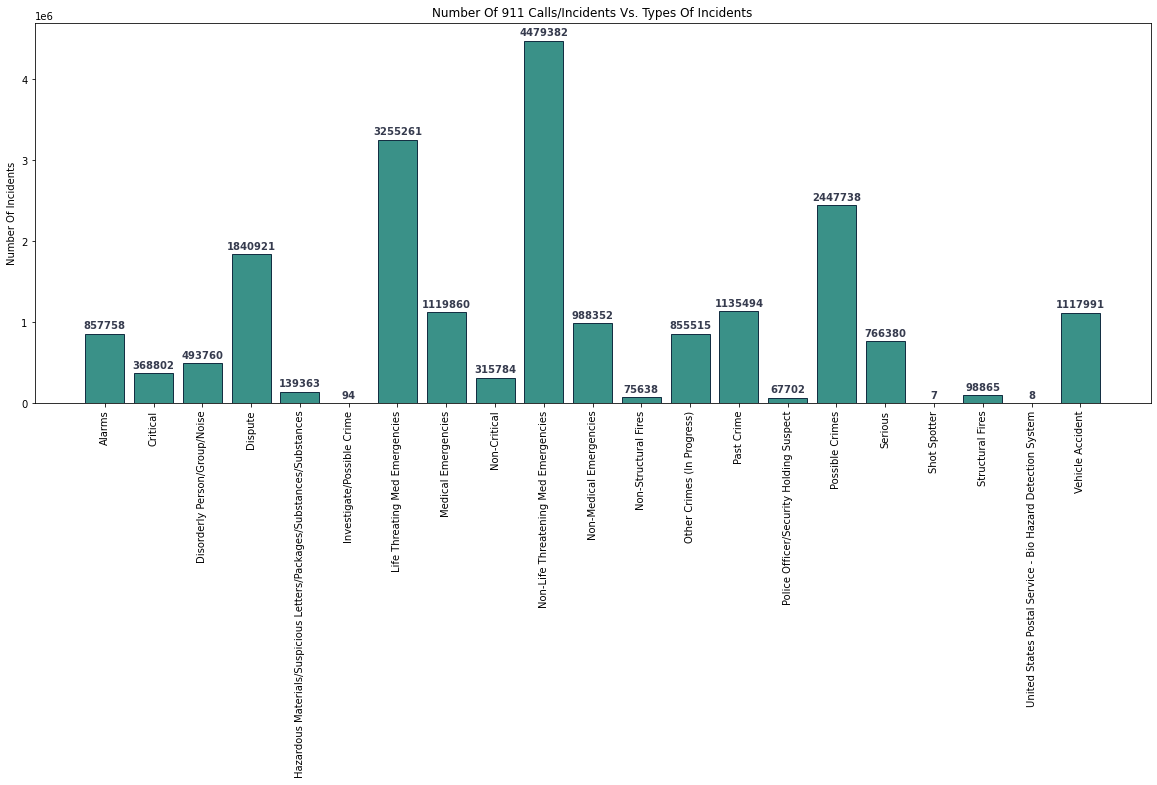

In [17]:
sql_statement = "SELECT i.Type, SUM(No_of_Incidents) AS 'Number Of Incidents' FROM ((AgencyIncident ai JOIN Agency a ON ai.AgencyID = a.AgencyID) JOIN Incident i ON ai.IncidentID = i.IncidentID) GROUP BY Type"
data = execute_sql_statement(sql_statement, conn_norm)

types = [i[0] for i in data]
incidents = [i[1] for i in data]

plt.rcParams['figure.figsize'] = [20,7]
plt.bar(types, incidents, color='#3A9188', edgecolor = '#142F43', linewidth = 1.0, tick_label = types)
plt.xticks(rotation=90)
plt.ylabel("Number Of Incidents")
plt.title("Number Of 911 Calls/Incidents Vs. Types Of Incidents")
plt.style.use('ggplot')

for i in range(len(types)):
        plt.text(i,incidents[i]+100000,incidents[i], animated = True, color = '#363B4E', fontsize = 'medium', fontweight = 'bold', horizontalalignment = 'center', rotation = 'horizontal', rotation_mode = 'anchor', verticalalignment = 'center')
        

Text(0.5, 1.0, 'Number Of 911 Calls/Incidents Vs. Responding Agencies')

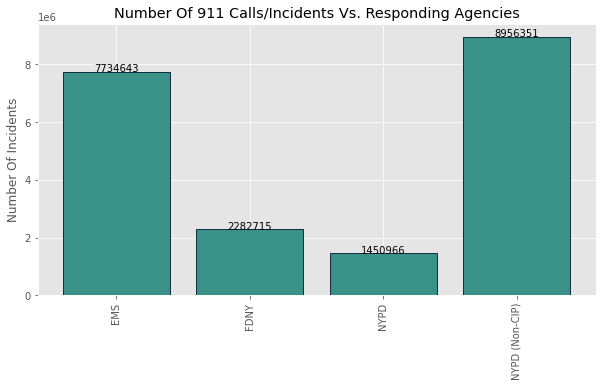

In [18]:
sql_statement = "SELECT a.Agency_Name, SUM(No_of_Incidents) AS 'Number Of Incidents' FROM ((AgencyIncident ai JOIN Agency a ON ai.AgencyID = a.AgencyID) JOIN Incident i ON ai.IncidentID = i.IncidentID) GROUP BY Agency_Name"
data = execute_sql_statement(sql_statement, conn_norm)

agency = [i[0] for i in data]
incidents = [i[1] for i in data]

plt.rcParams['figure.figsize'] = [10,5]
plt.bar(agency, incidents, color='#3A9188', edgecolor = '#142F43', linewidth = 1.0, tick_label = agency)

for i in range(len(agency)):
    plt.text(i, incidents[i], incidents[i], ha="center")

plt.xticks(rotation=90)
plt.ylabel("Number Of Incidents")
plt.title("Number Of 911 Calls/Incidents Vs. Responding Agencies")


In [19]:
sql = """SELECT * FROM AgencyIncident"""
df = pd.read_sql_query(sql, conn_norm)
display(df)

,RecordID,AgencyID,IncidentID,IncidentDate,Incident_Type,No_of_Incidents
0,1,1,7,12/29/2014,Life Threating Med Emergencies,8881
1,2,1,10,12/29/2014,Non-Life Threatening Med Emergencies,12594
2,3,2,19,12/29/2014,Structural Fires,341
3,4,2,12,12/29/2014,Non-Structural Fires,168
4,5,2,8,12/29/2014,Medical Emergencies,3054
...,...,...,...,...,...,...
6343,6344,4,13,01/07/2019,Other Crimes (In Progress),2720
6344,6345,4,14,01/07/2019,Past Crime,3200
6345,6346,4,15,01/07/2019,Police Officer/Security Holding Suspect,195
6346,6347,4,16,01/07/2019,Possible Crimes,7361


In [20]:
sql_statement = "SELECT f.IncidentID, f.CallToFDNYPickup, i.Type FROM FD f JOIN Incident i WHERE f.IncidentID = i.IncidentID"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)

,IncidentID,CallToFDNYPickup,Type
0,7,,Life Threating Med Emergencies
1,10,,Non-Life Threatening Med Emergencies
2,19,,Structural Fires
3,12,,Non-Structural Fires
4,8,,Medical Emergencies
...,...,...,...
6343,13,,Other Crimes (In Progress)
6344,14,,Past Crime
6345,15,,Police Officer/Security Holding Suspect
6346,16,,Possible Crimes


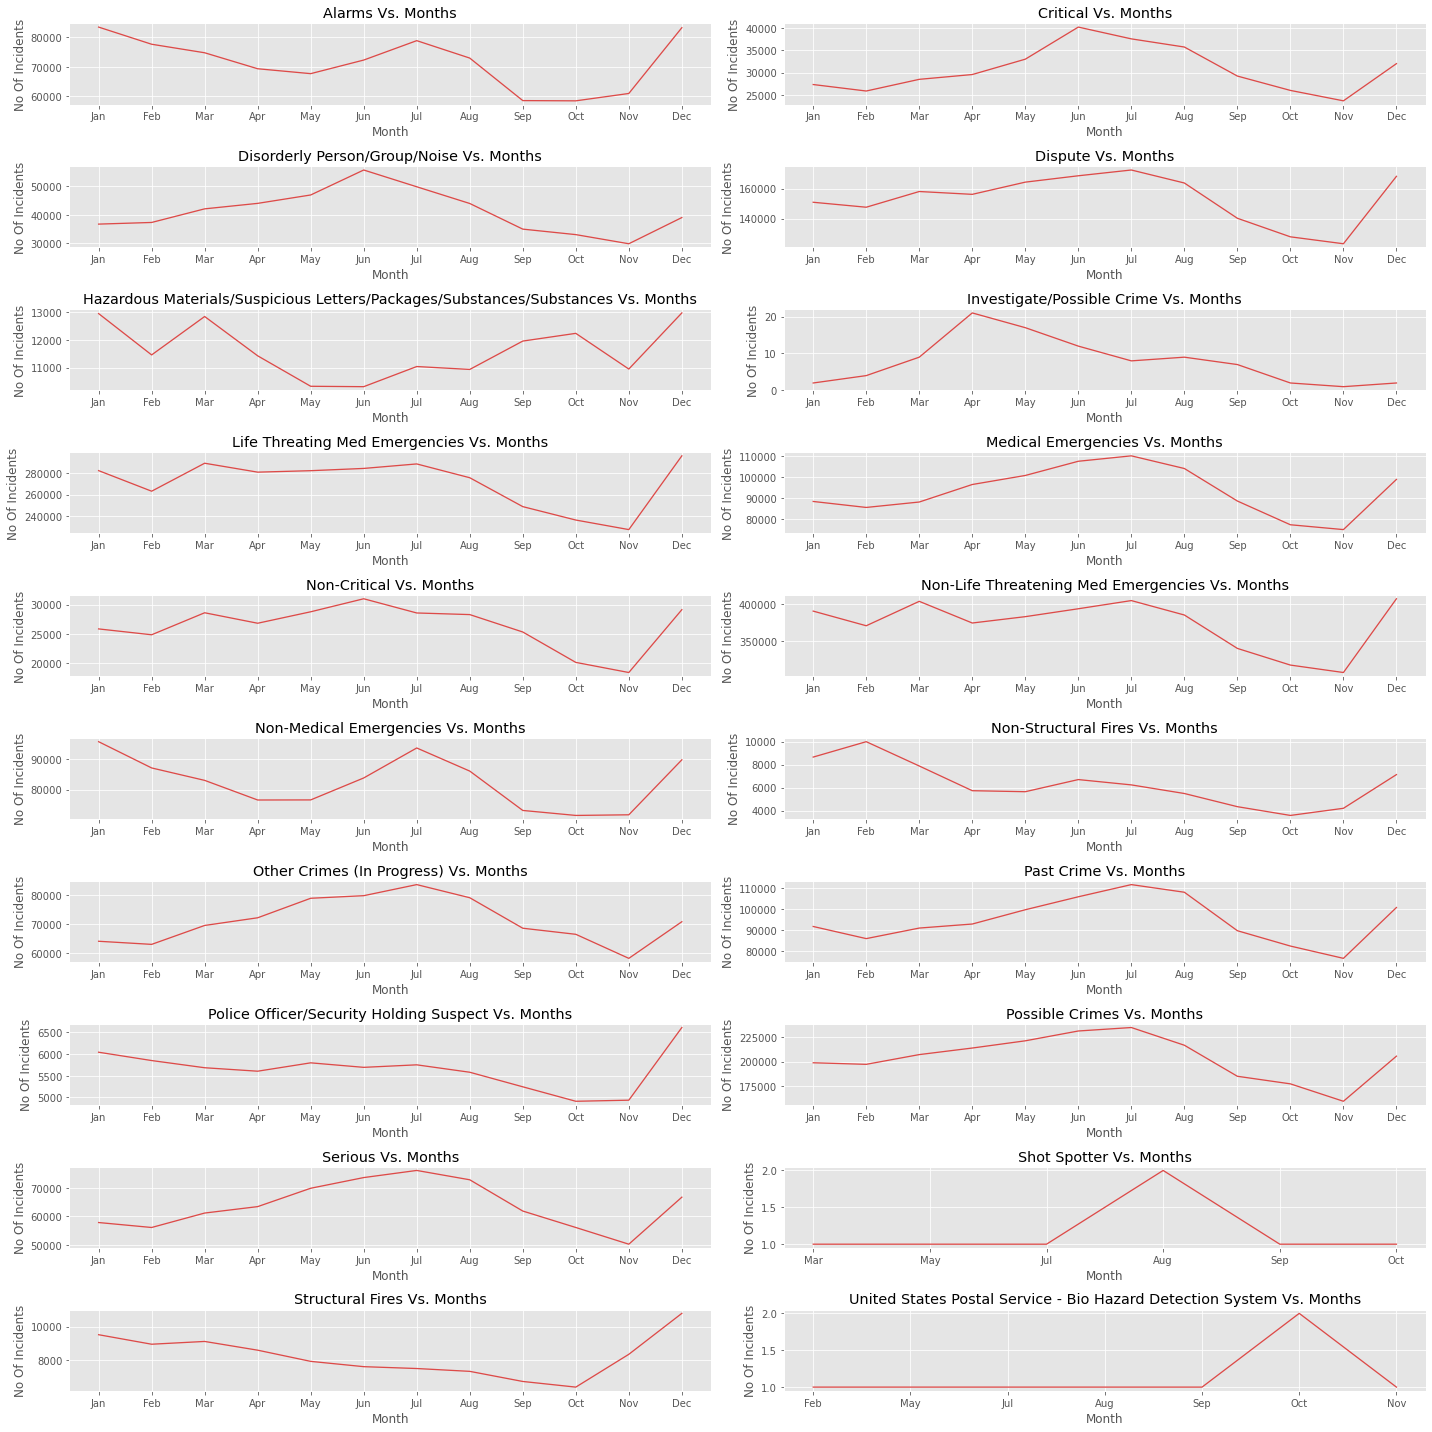

In [21]:
month = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}
inc_type={}
inc_mon = {}

sql_statement = "SELECT Incident_Type,SUM(No_of_Incidents),substr(IncidentDate,1,2) as Num  FROM AgencyIncident GROUP BY Incident_Type,Num"
data = execute_sql_statement(sql_statement, conn_norm)

plt.rcParams['figure.figsize'] = [20,20]

for record in data:
    if inc_type.get(record[0]):
        inc_type[record[0]].append(record[1])
        inc_mon[record[0]].append(month[record[2]])
    else:
        inc_type[record[0]] = [record[1],]
        inc_mon[record[0]] = [month[record[2]],]

for inc, ind in enumerate(inc_type.keys()):
    if(inc>=20):
        break
    plt.subplot(10, 2, inc+1)
    plt.plot(inc_mon[ind],inc_type[ind], linewidth = 1.3, color = '#DD4A48')
    plt.xlabel("Month")
    plt.ylabel("No Of Incidents")
    plt.title(ind +  " Vs. Months")
    plt.tight_layout()


In [22]:
sql_statement = """SELECT * FROM [EXPLORE911]"""
data = execute_sql_statement(sql_statement, conn)
df = pd.read_sql_query(sql_statement, conn)

latitude = [i[0] for i in data]
longitude = [i[1] for i in data]
zip = [i[2] for i in data]
title = [i[3] for i in data]
timestamp = [i[4] for i in data]

In [23]:
df['TimeStamp'] = df['TimeStamp'].apply(pd.Timestamp)

In [24]:
df['Year'] = df.TimeStamp.dt.year
df['Month'] = df.TimeStamp.dt.month
df["Hour"] = df.TimeStamp.dt.hour
df["Day"] = df.TimeStamp.dt.day_name().astype(str)
df['Reason'] = df['Title'].apply(lambda i:i.split(':')[0])
display(df)

,Latitude,Longitude,ZipCode,Title,TimeStamp,Year,Month,Hour,Day,Reason
0,40.297876,-75.581294,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,2015,12,17,Thursday,EMS
1,40.258061,-75.264680,19446,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,2015,12,17,Thursday,EMS
2,40.121182,-75.351975,19401,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,2015,12,14,Thursday,Fire
3,40.116153,-75.343513,19401,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,2015,12,16,Thursday,EMS
4,40.251492,-75.603350,,EMS: DIZZINESS,2015-12-10 16:56:52,2015,12,16,Thursday,EMS
...,...,...,...,...,...,...,...,...,...,...
663517,40.157956,-75.348060,19403,Traffic: VEHICLE ACCIDENT -,2020-07-29 15:46:51,2020,7,15,Wednesday,Traffic
663518,40.136306,-75.428697,19403,EMS: GENERAL WEAKNESS,2020-07-29 15:52:19,2020,7,15,Wednesday,EMS
663519,40.013779,-75.300835,19041,EMS: VEHICLE ACCIDENT,2020-07-29 15:52:52,2020,7,15,Wednesday,EMS
663520,40.121603,-75.351437,19401,Fire: BUILDING FIRE,2020-07-29 15:54:08,2020,7,15,Wednesday,Fire


In [25]:
#Calculating the Hours of a day that has the most 911 Call Frequency

temp = df.groupby("Hour")
temp1 = temp.count()["TimeStamp"]
temp2 = temp1.sort_values(ascending=False)
temp_final = temp2.head(5)

freq_hours = pd.DataFrame(temp_final)
freq_hours.columns = ["Calls"]

In [26]:
freq_hours.style.background_gradient()

,Calls
Hour,
17,44119
16,42797
15,42263
14,40346
12,40097


In [27]:
#Calculating the DAYS OF THE WEEK that has the most 911 Call Frequency

temp = df.groupby("Day")
temp1 = temp.count()["TimeStamp"]
temp2 = temp1.sort_values(ascending = False)
temp_final = temp2.head(5)

freq_days = pd.DataFrame(temp_final)
freq_days.columns = ["Calls"]

In [28]:
freq_days.style.background_gradient()

,Calls
Day,
Friday,102942
Wednesday,99157
Thursday,98683
Tuesday,97684
Monday,96745


In [29]:
df = df.loc[df["Year"] != 2015]

In [30]:
EMS = df[df['Reason'] == 'EMS'].groupby('Month').count()
Fire = df[df['Reason'] == 'Fire'].groupby('Month').count()
Traffic = df[df['Reason'] == 'Traffic'].groupby('Month').count()
Total = df.groupby('Month').count()

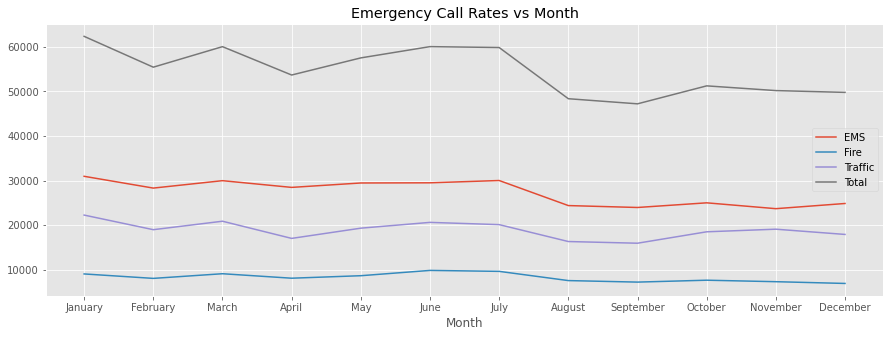

In [31]:
EMS['ZipCode'].plot(figsize=(15,5), label='EMS')
Fire['ZipCode'].plot(figsize=(15,5), label='Fire')
Traffic['ZipCode'].plot(figsize=(15,5), label='Traffic')
Total['ZipCode'].plot(figsize=(15,5), label='Total')

fig = plt.xticks(np.arange(1,13),['January','February','March','April','May','June','July','August','September','October','November','December'])
plt.title("Emergency Call Rates vs Month")
plt.legend(loc='center right')

Text(-9.075000000000003, 0.5, 'Counts')

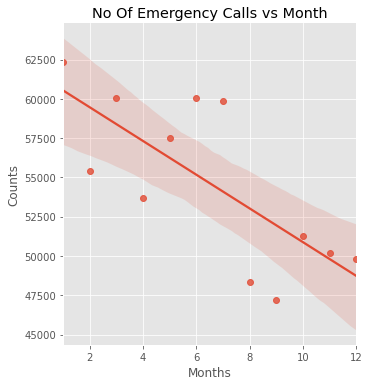

In [32]:
sns.lmplot(data = Total.reset_index(),x='Month',y='ZipCode')
plt.title("No Of Emergency Calls vs Month")
plt.xlabel('Months')
plt.ylabel('Counts')

In [33]:
EMS = df[df['Reason'] == 'EMS'].groupby('Year').count()
Fire = df[df['Reason'] == 'Fire'].groupby('Year').count()
Traffic = df[df['Reason'] == 'Traffic'].groupby('Year').count()
Total = df.groupby('Year').count()

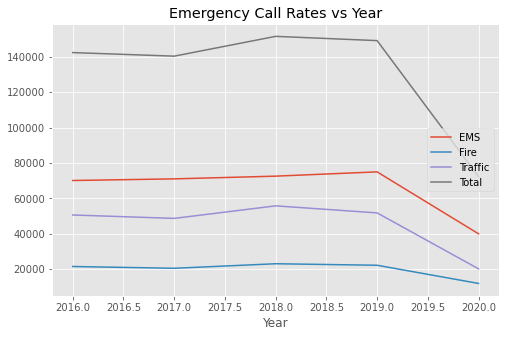

In [34]:
EMS['ZipCode'].plot(figsize=(8,5), label='EMS')
Fire['ZipCode'].plot(figsize=(8,5), label='Fire')
Traffic['ZipCode'].plot(figsize=(8,5), label='Traffic')
Total['ZipCode'].plot(figsize=(8,5), label='Total')

plt.rcParams['figure.figsize'] = [15,10]
plt.title("Emergency Call Rates vs Year")
plt.legend(loc='center right')

Text(-15.450000000000003, 0.5, 'Counts')

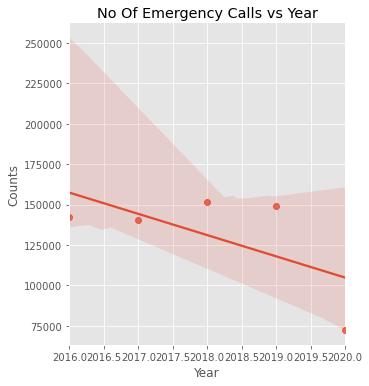

In [35]:
plt.rcParams['figure.figsize'] = [25,25]
sns.lmplot(data = Total.reset_index(),x='Year',y='ZipCode')
plt.title("No Of Emergency Calls vs Year")
plt.xlabel('Year')
plt.ylabel('Counts')



---
---



In [36]:
sql_statement = "SELECT * FROM [OPEN DATA]"
data = execute_sql_statement(sql_statement, conn)
df = pd.read_sql_query(sql_statement, conn)
df = df.drop(0, axis=0)
df["ResponseTime"] = df["ResponseTime"]/60
display(df)

,MonthName,Agency,Description,Borough,NoOfIncidents,ResponseTime
1,2014 / 12,FDNY,Average response time to structural fires,Bronx,710,5.181167
2,2014 / 12,FDNY,Average response time to structural fires,Brooklyn,910,4.452667
3,2014 / 12,FDNY,Average response time to structural fires,Manhattan,642,4.953667
4,2014 / 12,FDNY,Average response time to structural fires,Queens,548,5.2325
5,2014 / 12,FDNY,Average response time to structural fires,Staten Island,138,6.2555
...,...,...,...,...,...,...
6043,2019 / 01,FDNY,Percentage of response time to structural and ...,Brooklyn,1282,0.002667
6044,2019 / 01,FDNY,Percentage of response time to structural and ...,Manhattan,834,0.012
6045,2019 / 01,FDNY,Percentage of response time to structural and ...,Queens,868,0.0
6046,2019 / 01,FDNY,Percentage of response time to structural and ...,Staten Island,156,0.0


In [37]:
df['MonthName'] = df['MonthName'].apply(pd.Timestamp)
df['Year'] = df.MonthName.dt.year
df['Month'] = df.MonthName.dt.month
df = df.loc[df["Year"] != 2013]

In [38]:
Total = df.groupby('Year').count()

Text(-2.700000000000003, 0.5, 'Counts')

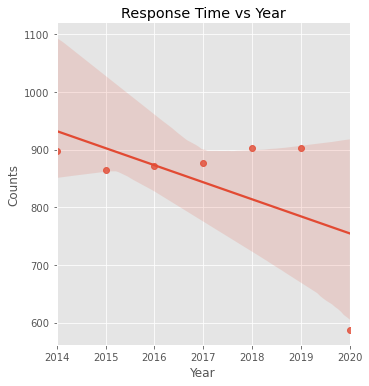

In [39]:
sns.lmplot(data = Total.reset_index(),x='Year',y='ResponseTime')
plt.title("Response Time vs Year")
plt.xlabel('Year')
plt.ylabel('Counts')

In [40]:
# inc_type={}
# inc_year = {}

# sql_statement = "SELECT Incident_Type,SUM(No_of_Incidents),substr(IncidentDate, 7) as Year  FROM AgencyIncident GROUP BY Incident_Type, Year"
# data = execute_sql_statement(sql_statement, conn_norm)


# for record in data:
#     if inc_type.get(record[0]):
#         inc_type[record[0]].append(record[1])
#         inc_year[record[0]].append(record[2])
#     else:
#         inc_type[record[0]] = [record[1],]
#         inc_year[record[0]] = [record[2],]

# print(inc_type)
# print(inc_year)
        

# for inc, ind in enumerate(inc_type.keys()):
#     if(inc>=20):
#         break
#     plt.rcParams['figure.figsize'] = [23,29]
#     plt.subplot(10, 2, inc+1)
#     plt.plot(inc_year[ind],inc_type[ind], linewidth = 1.3, color = '#DD4A48')
#     plt.xlabel("Month")
#     plt.ylabel("No Of Incidents")
#     plt.title(ind)
#     plt.tight_layout()

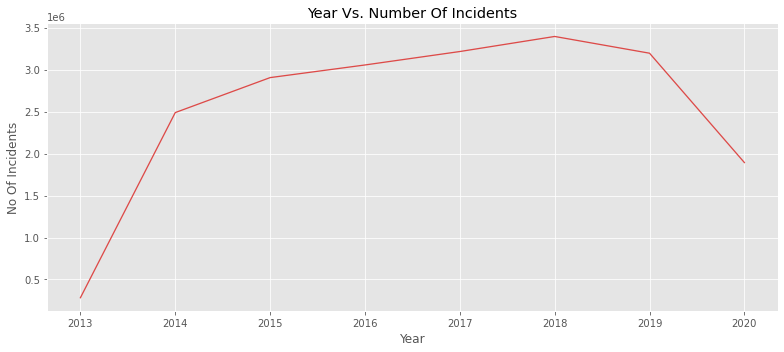

In [41]:

sql_statement = "SELECT SUM(No_of_Incidents),substr(IncidentDate, 7) as Year  FROM AgencyIncident GROUP BY Year"
data = execute_sql_statement(sql_statement, conn_norm)

inc_no = [i[0] for i in data]
inc_year = [i[1] for i in data]

plt.rcParams['figure.figsize'] = [11,5]
plt.plot(inc_year,inc_no, linewidth = 1.3, color = '#DD4A48')
plt.xlabel("Year")
plt.ylabel("No Of Incidents")
plt.title("Year Vs. Number Of Incidents")

plt.tight_layout()

In [42]:

sql = """SELECT * FROM ENDTOEND"""
endtoend = pd.read_sql_query(sql, conn)

endtoend.describe()

## Add observation from the description - range of response time, etc...

,NoOfIncidents,CallToFirstPickup,CallToPDCalltakerHandoff,CallToAgencyDispatch,CallToAgencyArrival,CallToFirstArrival,MedianPickup,MedianCalltakerHandoff,MedianDispatch,MedianTravel,MedianCummulativeFirstArrival,AverageTravel,AverageDispatch,AverageCalltakerProcessing,AveragePickup
count,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000
mean,3217.497637,3.534515,136.112881,473.242634,1508.753368,1410.844553,3.013469,105.114800,136.454592,616.024023,930.904931,17.258518,5.539072,2.200816,0.058628
std,3382.184270,1.114673,50.043845,349.707118,1183.562548,1171.730690,0.344348,39.991928,140.000918,547.559363,764.545696,15.278787,5.493788,0.834927,0.018850
min,1.000000,-46.680000,-0.840000,75.050000,114.000000,114.000000,2.000000,14.000000,6.000000,1.000000,114.000000,0.020000,0.120000,-0.070000,-0.780000
25%,691.250000,3.250000,102.677500,204.967500,518.652500,465.052500,3.000000,79.000000,56.000000,255.000000,384.000000,4.900000,1.450000,1.630000,0.050000
50%,2425.000000,3.510000,142.900000,358.730000,1023.590000,944.885000,3.000000,104.000000,98.000000,401.500000,609.000000,10.325000,3.540000,2.300000,0.060000
75%,3703.000000,3.730000,168.110000,724.940000,2389.717500,2285.600000,3.000000,135.000000,218.000000,850.750000,1362.250000,27.250000,9.480000,2.740000,0.060000
max,17613.000000,37.690000,806.250000,4331.000000,11536.000000,11536.000000,23.500000,496.000000,4231.000000,11300.000000,11536.000000,188.330000,70.520000,13.370000,0.630000


In [43]:
sql_statement = "SELECT AverageCalltakerProcessing,CallToAgencyDispatch, AverageTravel, AverageDispatch, substr(WeekStartDate, 7) as Year  FROM ENDTOEND"
data = execute_sql_statement(sql_statement, conn)


avg_ccal = [i[0]/60 for i in data]
agn_dis = [i[1]/60 for i in data]
avg_trav = [i[2]/60 for i in data]
avg_dis = [i[3]/60 for i in data]
inc_year = [int(i[4].strip()) for i in data]


plt.rcParams['figure.figsize'] = [11,5]

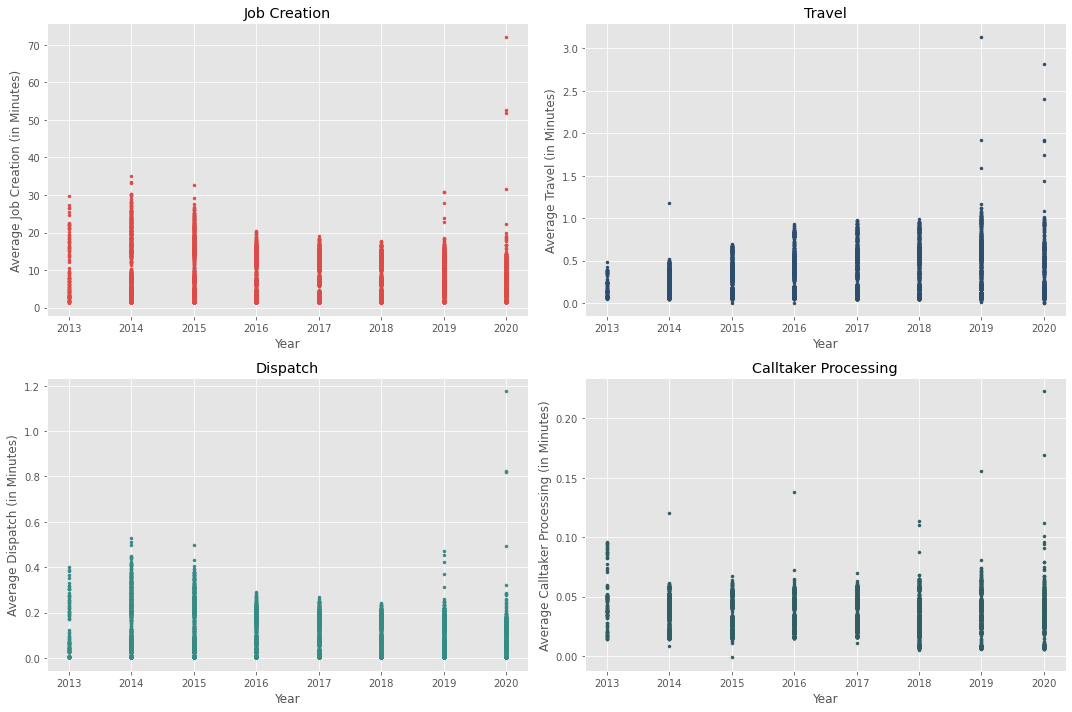

In [44]:
plt.rcParams['figure.figsize'] = [15,10]

plt.subplot(2, 2, 1)
plt.scatter(inc_year, agn_dis, color = '#DD4A48', marker = '.')
plt.xlabel("Year")
plt.ylabel("Average Job Creation (in Minutes)")
plt.title("Job Creation")
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.scatter(inc_year, avg_trav, color = '#2E4C6D', marker = '.')
plt.xlabel("Year")
plt.ylabel("Average Travel (in Minutes)")
plt.title("Travel")
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.scatter(inc_year, avg_dis, color = '#368B85', marker = '.')
plt.xlabel("Year")
plt.ylabel("Average Dispatch (in Minutes)")
plt.title("Dispatch")
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.scatter(inc_year, avg_ccal, color = '#2F5D62', marker = '.')
plt.xlabel("Year")
plt.ylabel("Average Calltaker Processing (in Minutes)")
plt.title("Calltaker Processing")
plt.tight_layout()

# --------------------------------------------------------------------

# Regression and Classification

In [45]:
sql = "SELECT * FROM [ENDTOEND]"
endtoend = pd.read_sql_query(sql, conn)
endtoend = endtoend.drop(0)

display(endtoend)

sql = "SELECT * FROM [OPEN DATA]"
opendata = pd.read_sql_query(sql, conn)
opendata = opendata.drop(0)

,WeekStartDate,Agency,FinalIncidentType,NoOfIncidents,CallToFirstPickup,CallToPDCalltakerHandoff,CallToFDNYPickup,CallToFDNYJobCreation,CallToEMSPickup,CallToAgencyJobCreation,...,MedianTravel,MedianCummulativeFirstArrival,AverageTravel,AverageDispatch,AverageEMSProcessing,AverageEMSPickup,AverageCalltakerProcessing,AveragePickup,AverageFDPickup,AverageFDProcessing
1,12/29/2014,EMS,Non-Life Threatening Med Emergencies,12594,3.03,69.63,,,77.76,125.53,...,441.0,571.5,8.42,2.67,0.66,0.16,1.11,0.05,,
2,12/29/2014,FDNY,Structural Fires,341,3.09,71.82,,,,,...,190.0,267.0,3.25,0.20,,,1.15,0.05,,
3,12/29/2014,FDNY,Non-Structural Fires,168,3.07,80.86,,,,,...,235.0,327.0,4.20,0.24,,,1.30,0.05,,
4,12/29/2014,FDNY,Medical Emergencies,3054,3.02,154.83,,,66.45,151.56,...,243.0,375.0,4.26,0.39,1.45,0.1,2.53,0.05,,
5,12/29/2014,FDNY,Non-Medical Emergencies,2399,3.07,142.08,,,,,...,251.0,351.0,4.68,0.26,,,2.32,0.05,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,01/07/2019,NYPD (Non-CIP),Other Crimes (In Progress),2720,3.58,152.76,,,,,...,305.0,599.0,9.52,3.13,,,2.49,0.06,,
6344,01/07/2019,NYPD (Non-CIP),Past Crime,3200,3.72,205.11,,,,,...,1531.0,2236.0,44.40,9.24,,,3.36,0.06,,
6345,01/07/2019,NYPD (Non-CIP),Police Officer/Security Holding Suspect,195,3.57,99.61,,,,,...,658.0,977.0,18.62,3.71,,,1.60,0.06,,
6346,01/07/2019,NYPD (Non-CIP),Possible Crimes,7361,3.56,148.94,,,,,...,1031.0,1549.0,33.97,7.78,,,2.42,0.06,,


In [46]:
opendata.drop(['MonthName', 'Description'], axis=1, inplace=True)
display(opendata)

,Agency,Borough,NoOfIncidents,ResponseTime
1,FDNY,Bronx,710,310.87
2,FDNY,Brooklyn,910,267.16
3,FDNY,Manhattan,642,297.22
4,FDNY,Queens,548,313.95
5,FDNY,Staten Island,138,375.33
...,...,...,...,...
6043,FDNY,Brooklyn,1282,0.16
6044,FDNY,Manhattan,834,0.72
6045,FDNY,Queens,868,0.0
6046,FDNY,Staten Island,156,0.0


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Modelling Linear Regression
## Predicting Response Time from No of incidents

In [48]:
X = opendata['NoOfIncidents'].values.reshape(-1, 1)
y = opendata['ResponseTime'].values.reshape(-1, 1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
model_fit_sv = LinearRegression()
model_fit_sv.fit(X_train, y_train)

LinearRegression()

In [50]:
y_pred = model_fit_sv.predict(X_test)
print('Accuracy of linear regression classifier on test set: {:.2f}'.format(model_fit_sv.score(X_test, y_test)))

Accuracy of linear regression classifier on test set: 0.18


In [51]:
predicted_value = model_fit_sv.predict(X_test)
# print(predicted_value)
# print(y_test)

## Model is fit with an intercept of c = 270.09031493 and coefficient of m = 0.01014759

In [52]:
intercept = model_fit_sv.intercept_
print(model_fit_sv.intercept_)

[270.09031493]


In [53]:
coeff = model_fit_sv.coef_
print(model_fit_sv.coef_)

[[0.01014759]]


## Single variable linear regression model fit 

Text(0.5, 1.0, 'Linear Regression to predict Response Time')

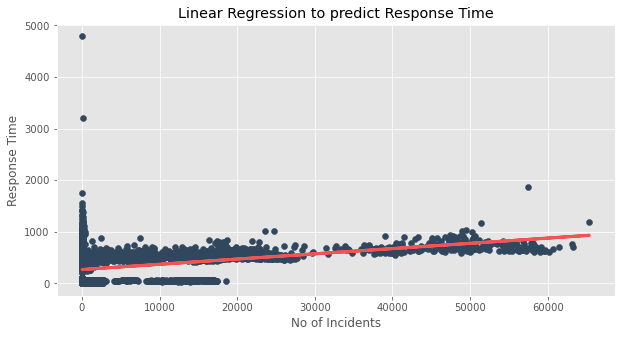

In [54]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(X, y,color='#30475E')
plt.plot(X, model_fit_sv.predict(X).tolist(),color='#F05454',linewidth = 3.0)
plt.xlabel("No of Incidents")
plt.ylabel("Response Time")
plt.title("Linear Regression to predict Response Time")

## Performing Multiple Linear Regression

In [55]:
opendata.head(3)

,Agency,Borough,NoOfIncidents,ResponseTime
1,FDNY,Bronx,710,310.87
2,FDNY,Brooklyn,910,267.16
3,FDNY,Manhattan,642,297.22


## Converting categorical variable into numerical variable through integer and one hot encoding

In [56]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(opendata['Agency'])
print(integer_encoded)

[2 2 2 ... 2 2 2]


In [57]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [58]:
opendata = pd.concat([opendata, pd.DataFrame(onehot_encoded, columns=['A1', 'A2', 'A3'])], axis=1)
opendata.drop(['Agency'], axis=1, inplace=True)
opendata = opendata.drop(0)
display(opendata)

,Borough,NoOfIncidents,ResponseTime,A1,A2,A3
1,Bronx,710,310.87,0.0,0.0,1.0
2,Brooklyn,910,267.16,0.0,0.0,1.0
3,Manhattan,642,297.22,0.0,0.0,1.0
4,Queens,548,313.95,0.0,0.0,1.0
5,Staten Island,138,375.33,0.0,0.0,1.0
...,...,...,...,...,...,...
6043,Brooklyn,1282,0.16,0.0,0.0,1.0
6044,Manhattan,834,0.72,0.0,0.0,1.0
6045,Queens,868,0.0,0.0,0.0,1.0
6046,Staten Island,156,0.0,0.0,0.0,1.0


In [59]:
print(opendata['Borough'].unique())
borough_encoded = label_encoder.fit_transform(opendata['Borough'])
print(borough_encoded)

['Bronx' 'Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Unspecified']
[0 1 2 ... 3 4 5]


In [60]:
onehot_encoder_bor = OneHotEncoder(sparse=False)
borough_encoded = borough_encoded.reshape(len(borough_encoded), 1)
onehot_encoder_bor = onehot_encoder_bor.fit_transform(borough_encoded)
print(onehot_encoder_bor)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [61]:
opendata = pd.concat([opendata, pd.DataFrame(onehot_encoder_bor, columns=['B1', 'B2', 'B3', 'B4', 'B5', 'B6'])], axis=1)
opendata.drop(['Borough'], axis=1, inplace=True)

In [62]:
opendata = opendata.drop(0)

In [63]:
opendata = opendata.drop(6047)
X = opendata.loc[:, opendata.columns != 'ResponseTime']
y = opendata['ResponseTime']
display(opendata)

,NoOfIncidents,ResponseTime,A1,A2,A3,B1,B2,B3,B4,B5,B6
1,710,310.87,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,910,267.16,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,642,297.22,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,548,313.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,138,375.33,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6042,796,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6043,1282,0.16,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6044,834,0.72,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6045,868,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Splitting data into training (80%) and test data (20%)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
model_fit = LinearRegression()
model_fit.fit(X_train, y_train)

LinearRegression()

In [65]:
y_pred = model_fit.predict(X_test)
print('Accuracy of linear regression classifier on test set: {:.2f}'.format(model_fit.score(X_test, y_test)))

Accuracy of linear regression classifier on test set: 0.35


In [66]:
predicted_value = model_fit.predict(X_test)
print(predicted_value)

[195.00522098 561.71188708 203.83520861 ... 334.99409389 699.61499645
 180.61213176]


## Model is fit with an intercept of c = 336.69.

In [67]:
intercept = model_fit.intercept_
print(model_fit.intercept_)
coeff = model_fit.coef_
print(model_fit.coef_)

336.690736638873
[ 8.64190089e-03  8.61167408e+01  3.57344312e+01 -1.21851172e+02
  1.18581703e+02 -1.75894845e+01 -7.03299852e+01 -3.87903566e+01
 -2.72145271e+01  3.53426501e+01]


In [68]:
su = (X*coeff).sum(axis=1)
fitted_line = su + intercept
# fitted_line

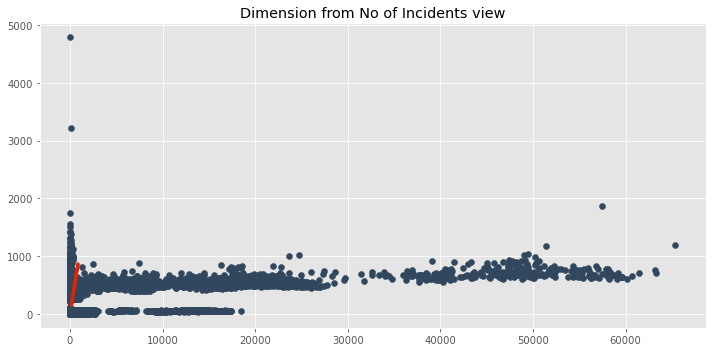

In [69]:
plt.scatter(X[['NoOfIncidents']], y,color='#30475E')
plt.plot(fitted_line, model_fit.predict(X).tolist(),color='#E02401',linewidth = 3.1)
plt.title("Dimension from No of Incidents view")
plt.tight_layout()

## Classifying the type of incident 

## Removing columns with numerous null values

In [70]:
## Cleaning the End to End Data
nyc_data = endtoend.copy()
print(endtoend.columns)
selected_columns = ['WeekStartDate','CallToFDNYJobCreation','CallToFDNYPickup','CallToEMSPickup','CallToFirstArrival','CallToAgencyJobCreation','MedianFDNYPickup','MedianFDNYJobCreation','MedianEMSPickup','MedianEMSJobCreation','AverageEMSProcessing','AverageEMSPickup','AverageFDPickup','AverageFDProcessing']
for i in endtoend.columns:
    if(endtoend[i].isnull().values.any()):
        selected_columns.append(i)
        
print(selected_columns)
nyc_data.drop(selected_columns, axis=1, inplace=True)

nyc_data.head(3)

Index(['WeekStartDate', 'Agency', 'FinalIncidentType', 'NoOfIncidents',
       'CallToFirstPickup', 'CallToPDCalltakerHandoff', 'CallToFDNYPickup',
       'CallToFDNYJobCreation', 'CallToEMSPickup', 'CallToAgencyJobCreation',
       'CallToAgencyDispatch', 'CallToAgencyArrival', 'CallToFirstArrival',
       'MedianPickup', 'MedianCalltakerHandoff', 'MedianFDNYPickup',
       'MedianFDNYJobCreation', 'MedianEMSPickup', 'MedianEMSJobCreation',
       'MedianDispatch', 'MedianTravel', 'MedianCummulativeFirstArrival',
       'AverageTravel', 'AverageDispatch', 'AverageEMSProcessing',
       'AverageEMSPickup', 'AverageCalltakerProcessing', 'AveragePickup',
       'AverageFDPickup', 'AverageFDProcessing'],
      dtype='object')
['WeekStartDate', 'CallToFDNYJobCreation', 'CallToFDNYPickup', 'CallToEMSPickup', 'CallToFirstArrival', 'CallToAgencyJobCreation', 'MedianFDNYPickup', 'MedianFDNYJobCreation', 'MedianEMSPickup', 'MedianEMSJobCreation', 'AverageEMSProcessing', 'AverageEMSPickup', 'Ave

,Agency,FinalIncidentType,NoOfIncidents,CallToFirstPickup,CallToPDCalltakerHandoff,CallToAgencyDispatch,CallToAgencyArrival,MedianPickup,MedianCalltakerHandoff,MedianDispatch,MedianTravel,MedianCummulativeFirstArrival,AverageTravel,AverageDispatch,AverageCalltakerProcessing,AveragePickup
1,EMS,Non-Life Threatening Med Emergencies,12594,3.03,69.63,251.21,756.23,3.0,80.5,95.0,441.0,571.5,8.42,2.67,1.11,0.05
2,FDNY,Structural Fires,341,3.09,71.82,84.10,278.87,3.0,59.0,10.0,190.0,267.0,3.25,0.20,1.15,0.05
3,FDNY,Non-Structural Fires,168,3.07,80.86,95.05,347.00,3.0,61.5,12.0,235.0,327.0,4.20,0.24,1.30,0.05


## Formatting the Incident Type column

In [71]:
## Data Preparation & Cleaning
def formatIncident(row):
    flag = False
    if(len(row.split('. '))>1):
        row = row.split('. ')[1]
        flag = True
    return(row,flag)
         
for n,i in enumerate(nyc_data["FinalIncidentType"]):
    dat,change = formatIncident(i)
    if(change):
        nyc_data.loc[nyc_data.index[n], "FinalIncidentType"] = dat
        
nyc_data.head(2)

,Agency,FinalIncidentType,NoOfIncidents,CallToFirstPickup,CallToPDCalltakerHandoff,CallToAgencyDispatch,CallToAgencyArrival,MedianPickup,MedianCalltakerHandoff,MedianDispatch,MedianTravel,MedianCummulativeFirstArrival,AverageTravel,AverageDispatch,AverageCalltakerProcessing,AveragePickup
1,EMS,Non-Life Threatening Med Emergencies,12594,3.03,69.63,251.21,756.23,3.0,80.5,95.0,441.0,571.5,8.42,2.67,1.11,0.05
2,FDNY,Structural Fires,341,3.09,71.82,84.10,278.87,3.0,59.0,10.0,190.0,267.0,3.25,0.20,1.15,0.05


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Converting categorical data into numerical values

In [73]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(nyc_data['Agency'])
print(integer_encoded)

[0 1 1 ... 3 3 3]


In [74]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [75]:
nyc_data = pd.concat([nyc_data, pd.DataFrame(onehot_encoded)], axis=1)
nyc_data.drop(['Agency'], axis=1, inplace=True)
nyc_data.head(2)

,FinalIncidentType,NoOfIncidents,CallToFirstPickup,CallToPDCalltakerHandoff,CallToAgencyDispatch,CallToAgencyArrival,MedianPickup,MedianCalltakerHandoff,MedianDispatch,MedianTravel,MedianCummulativeFirstArrival,AverageTravel,AverageDispatch,AverageCalltakerProcessing,AveragePickup,0,1,2,3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0
1,Non-Life Threatening Med Emergencies,12594.0,3.03,69.63,251.21,756.23,3.0,80.5,95.0,441.0,571.5,8.42,2.67,1.11,0.05,0.0,1.0,0.0,0.0


In [76]:
nyc_data = nyc_data.drop(0)
nyc_data = nyc_data.drop(6347)

X = nyc_data.loc[:, nyc_data.columns != 'FinalIncidentType']
y = nyc_data['FinalIncidentType']


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
model_fit = LogisticRegression()
model_fit.fit(X_train, y_train)

C:\Users\srisp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Classification model provides an accuracy of 83%

In [78]:
y_pred = model_fit.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model_fit.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                                                                       precision    recall  f1-score   support

                                                               Alarms       0.78      0.90      0.83        67
                                                             Critical       0.92      0.94      0.93        72
                                        Disorderly Person/Group/Noise       0.75      0.78      0.76        81
                                                              Dispute       0.93      0.82      0.87        80
Hazardous Materials/Suspicious Letters/Packages/Substances/Substances       0.98      0.97      0.98        65
                                           Investigate/Possible Crime       0.82      0.64      0.72        14
                                       Life Threating Med Emergencies       0.86      0.15      0.26        79
                                                  Medical Emergencies       0.88      0.83      0.86        71


C:\Users\srisp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srisp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srisp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
kl = model_fit.predict(X_test)
print(kl)

['Serious' 'Non-Structural Fires'
 'Police Officer/Security Holding Suspect' ... 'Alarms'
 'Medical Emergencies' 'Serious']


In [81]:
try:
    if conn:
        conn.close()
    if conn_norm:
        conn_norm.close()
except:
    pass

In [ ]:
####